## Easy 21
### Imports

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Environment

In [72]:
ACTIONS = ['HIT', 'STICK']
ACTION_TO_INDEX = {'HIT': 0, 'STICK': 1}


class GameState:
    def __init__(self, dealer, player, done):
        self.dealer = dealer
        self.player = player
        self.done = done
        
    def __repr__(self):
        return f"GameState dealer: {self.dealer}, player: {self.player}, done: {self.done}"
    
    def __str__(self):
        return f"GameState dealer: {self.dealer}, player: {self.player}, done: {self.done}"


def sample_card():
    value = random.randrange(1, 11)
    factor = 1 if random.random() < 0.7 else -1
    return value * factor


def is_busted(cards):
    return cards < 1 or cards > 21


def final_reward(state):
    if state.dealer == state.player:
        return 0
    elif state.dealer < state.player:
        return 1
    else:
        return -1


def reward(state):
    if is_busted(state.dealer):
        return 1
    elif is_busted(state.player):
        return -1
    else:
        if state.done:
            return final_reward(state)
        else:
            return 0

        
def next_state(state, action):
    if state.done:
        return state
    else:
        if action == ACTION_TO_INDEX['HIT']:
            player =  state.player + sample_card()
            return GameState(state.dealer, player, is_busted(player))
        elif action == ACTION_TO_INDEX['STICK']:
            temp = state
            while(not temp.done and temp.dealer < 17):
                dealer = temp.dealer + sample_card()
                temp = GameState(dealer, state.player, is_busted(dealer))
            return GameState(temp.dealer, state.player, True)
        else:
            return state

        
def initial_state():
    return GameState(random.randrange(1, 11), random.randrange(1, 11), False)

    
def step(state, action):
    state = next_state(state, action)
    return (state, reward(state))

### Monte Carlo Control

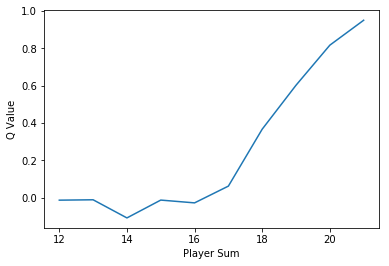

In [74]:
n_0 = 100
n_t = np.zeros((10,21))
n_values = np.zeros((10,21,2))
q_values = np.zeros((10,21,2))


class Step:
    def __init__(self, state, action, reward, next_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = next_state
    
    def __repr__(self):
        return f"Step state: {self.state}, action: {ACTIONS[self.action]}, reward: {self.reward}, next_state: {self.next_state}"
    
    def __str__(self):
        return f"Step state: {self.state}, action: {ACTIONS[self.action]}, reward: {self.reward}, next_state: {self.next_state}"

    
def sample_episode():
    state = initial_state()
    episode = []
    while not state.done:
        epsilon = n_0 / (n_0 + n_t[(state.dealer-1, state.player-1)])
        action = e_greedy(epsilon, state)
        next_state, reward = step(state, action)
        episode.append(Step(state, action, reward, next_state))
        state = next_state
    return episode


def e_greedy(epsilon, state):
    max_action = np.argmax(q_values[(state.dealer-1, state.player-1)])
    random_action = random.randrange(2)
    return max_action if random.random() > epsilon else random_action


def update_values(episode):
    reward = episode[-1].reward
    for step in episode:
        n_t[(step.state.dealer-1, step.state.player-1)] += 1
        n_values[(step.state.dealer-1, step.state.player-1, step.action)] += 1
        step_size = 1 / n_values[(step.state.dealer-1, step.state.player-1, step.action)]
        q_update = reward - q_values[(step.state.dealer-1, step.state.player-1, step.action)]
        q_values[(step.state.dealer-1, step.state.player-1, step.action)] += step_size * q_update
       
        
def monte_carlo_control(n_iterations):
    for i in range(n_iterations):
        episode = sample_episode()
        update_values(episode)

        
monte_carlo_control(500000)
plt.plot(np.arange(12,22), np.amax(np.average(q_values[:,11:,:], axis=0), axis=1))
plt.xlabel('Player Sum')
plt.ylabel('Q Value')
plt.show()

## Test

In [82]:
def greedy(state):
    return np.argmax(q_values[(state.dealer-1, state.player-1)])


def play(n_rounds):
    rewards = []
    for _ in range(n_rounds):
        state = initial_state()
        while not state.done:
            action = greedy(state)
            state = next_state(state, action)
        rewards.append(reward(state))
    
    wins = 0
    draws = 0
    loss = 0
    for r in rewards:
        if r == 1:
            wins += 1
        elif r == -1:
            loss += 1
        else:
            draws += 1
            
    total_reward = sum(rewards)
    win_rate = round(wins / n_rounds * 100, 2)
    draw_rate = round(draws / n_rounds * 100, 2)
    loss_rate = round(loss / n_rounds * 100, 2)
    
    print(f"Played {n_rounds} rounds")
    print(f"Total reward: {total_reward}")
    print(f"Wins {win_rate}%, draws {draw_rate}%, loss {loss_rate}%")


play(5000)

Played 5000 rounds
Total reward: 32
Wins 50.08%, draws 0.48%, loss 49.44%


In [84]:
def input_play():
    state = initial_state()
    while not state.done:
        print(state)
        action = ACTION_TO_INDEX[input()]
        state = next_state(state, action)
    print(state)
    ['LOSE']
    print(f"YOU {'WIN' if reward(state)}")


input_play()

GameState dealer: 3, player: 4, done: False
HIT
GameState dealer: 3, player: 9, done: False
HIT
GameState dealer: 3, player: 13, done: False
HIT
GameState dealer: 3, player: 10, done: False
HIT
GameState dealer: 3, player: 6, done: False
HIT
GameState dealer: 3, player: 9, done: False
HIT
GameState dealer: 3, player: 18, done: False
STICK
GameState dealer: -1, player: 18, done: True
1
